# Advanced Machine Learning - Exercise 1
Dominique Cheray & Manuel Krämer

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold, train_test_split
import random
import matplotlib.pyplot as plt

## 1) Loading the Dataset

In [2]:
digits = load_digits()
print(digits.keys())

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

print(data.dtype)

# reduced X and target vector Y
X = data[(target == 3) | (target == 8)]
X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
print(X.shape)
Y = target[(target == 3) | (target == 8)]
Y[Y == 3] = 1
Y[Y == 8] = -1
print(Y.shape)

dict_keys(['images', 'DESCR', 'target', 'data', 'target_names'])
float64
(357, 65)
(357,)


### 1.1) Classification with sklearn

In [3]:
for i in np.arange(0.01,1,0.01):
    logreg = LogisticRegression( C=i, random_state=None, max_iter=100)
    cv_results = cross_validate(logreg, X, Y)
    print("Test score for lambda={:.3f}: ".format(i), np.mean(cv_results['test_score']))


Test score for lambda=0.010:  0.9719887955182074
Test score for lambda=0.020:  0.9747899159663866
Test score for lambda=0.030:  0.9775910364145659
Test score for lambda=0.040:  0.9775910364145659
Test score for lambda=0.050:  0.9803921568627452
Test score for lambda=0.060:  0.9803921568627452
Test score for lambda=0.070:  0.9803921568627452
Test score for lambda=0.080:  0.9803921568627452
Test score for lambda=0.090:  0.9803921568627452
Test score for lambda=0.100:  0.9803921568627452
Test score for lambda=0.110:  0.9803921568627452
Test score for lambda=0.120:  0.9803921568627452
Test score for lambda=0.130:  0.9803921568627452
Test score for lambda=0.140:  0.9803921568627452
Test score for lambda=0.150:  0.9803921568627452
Test score for lambda=0.160:  0.9803921568627452
Test score for lambda=0.170:  0.9803921568627452
Test score for lambda=0.180:  0.9803921568627452
Test score for lambda=0.190:  0.9803921568627452
Test score for lambda=0.200:  0.9803921568627452
Test score for lambd

### 1.2) Optimization methods

In [4]:
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))


def gradient(beta, X, y):
    N = X.shape[0]
    # formula as given in lecture
    return (1/N) * (np.dot(sigmoid((np.dot(np.dot(y, X), beta) *-1)), (-1 * (np.dot(y, X)))) + (beta / lambd))

def predict(beta, X):
    prediction = np.dot(X, beta)
    prediction[prediction <= 0] = -1
    prediction[prediction > 0] = 1
    return prediction


def zero_one_loss(y_prediction, y_truth):
    N = len(y_truth)
    return (N - np.sum(np.equal(y_prediction, y_truth)))


def gradient_descent(X, y, beta, tau, gamma, m):
    for t in range(m):
        beta = beta - tau * gradient(beta, X, y)
    return beta


def stochastic_gradient(X, y, beta, tau, gamma, m):
    tau_zero = tau
    indices = list(range(0, X.shape[0]))
    random.shuffle(indices)   
    for t in range(m):
        beta = beta - tau * gradient(beta, X[indices[t]], y[indices[t]])
        tau = tau_zero / (1 + gamma * t)
    return beta


def stochastic_gradient_minibatch(X, y, beta, tau, gamma, m):
    tau_zero = tau
    for t in range(m):
        rand_indices = random.sample(range(0, (X.shape[0] - 1)), 10)
        beta = beta - tau * gradient(beta, X[rand_indices], y[rand_indices])
        tau = tau_zero / (1 + gamma * t)
    return beta


def stochastic_gradient_momentum(X, y, beta, tau, gamma, g, mu, m):
    tau_zero = tau
    indices = list(range(0, X.shape[0]))
    random.shuffle(indices)
    for t in range(m):
        g = mu * g + (1 - mu) * gradient(beta, X[indices[t]], y[indices[t]])
        beta = beta - tau * g
        tau = tau_zero / (1 + gamma * t)
    return beta


def ADAM(X, y, beta, g, m):
    mu_one = 0.9
    mu_two = 0.999
    tau = 10e-4
    epsilon = 10e-8
    q = np.zeros((X.shape[1]))
    indices = list(range(0, X.shape[0]))
    random.shuffle(indices)
    for t in range(m):
        loss_gradient = gradient(beta, X[indices[t]], y[indices[t]])
        g = mu_one * g + (1 - mu_one) * loss_gradient
        q = mu_two * q + (1 - mu_two) * np.dot(loss_gradient, loss_gradient)
        g_tilde = g / (1 - mu_one)
        q_tilde = q / (1 - mu_two)
        beta = beta - (tau / (np.sqrt(q_tilde) + epsilon)) * g_tilde
    return beta


def stochastic_average_gradient(X, y, beta, tau, gamma, m):
    tau_zero = tau
    N = X.shape[0]
    g_stored = ((-(np.dot(y, X))) * sigmoid(-(np.dot(np.dot(y, X),  beta))))
    g_t = g_stored / N
    indices = list(range(0, X.shape[0]))
    random.shuffle(indices)
    for t in range(m):
        g_t = (sigmoid(-(np.dot(np.dot(X[indices[t]].T, y[indices[t]]), beta))) * (-1 * (np.dot(X[indices[t]].T, y[indices[t]]))))
        g = g_t + (1 / N) * (g_t - g_stored)
        g_stored = g_t
        beta = beta * (1 - tau / lambd) - tau * g
        tau = tau_zero / (1 + gamma * t)
    return beta


def dual_coordinate_ascent(X, y, m):
    N = X.shape[0]
    alpha = np.random.random(X.shape[1])
    beta = (lambd / N) * alpha * np.dot(y, X)
    eps = 0.0001
    indices = list(range(0, X.shape[0]))
    random.shuffle(indices)
    for t in range(m):
        f_prime = np.dot(np.dot(y[indices[t]], X[indices[t]]), beta) * np.log(alpha / (1 - alpha))
        f_double_prime = lambd/N * np.dot(X[indices[t]].T, X[indices[t]]) + 1 / (alpha * (1 - alpha))
        alpha_plus_one = alpha - f_prime / f_double_prime
        alpha_plus_one = np.clip(alpha_plus_one, eps, (1-eps))
        beta = beta + (lambd / N) * (np.dot(y[indices[t]], X[indices[t]]) * (alpha_plus_one - alpha))
        alpha = alpha_plus_one
    return beta


def newton_raphson(X, y, beta, m):
    N = X.shape[0]
    I = np.identity(X.shape[1])
    for i in range(m):
        z = np.dot(X, beta)
        y_tilde = y / sigmoid((y * z))
        W = np.diag(((lambd / N) * sigmoid(z) * sigmoid((-z))))
        beta = np.dot(np.dot(np.dot(np.linalg.inv((I + np.dot(np.dot(X.T, W), X))), X.T), W), (z + y_tilde))
    return beta

### 1.3) Comparison

In [5]:

# 1.3) Comparison

lambd = 0.8
np.random.seed(5)
taus = [0.001, 0.01, 0.1]
mus = [0.1, 0.2, 0.5]
gammas = [0.0001, 0.001, 0.01]

errors = np.zeros((18))
bet_zero = np.zeros((65))
g_zero = np.zeros((65))
kf = KFold(n_splits=10)

for train, validation in kf.split(X):
    X_train, X_validation = X[train], X[validation]
    y_train, y_validation = Y[train], Y[validation]

    bet_m = gradient_descent(X_train, y_train, bet_zero, taus[0], gammas[0], 10)
    errors[0] = zero_one_loss(y_validation, (predict(bet_m, X_validation)))

    bet_m = gradient_descent(X_train, y_train, bet_zero, taus[1], gammas[1], 10)
    errors[1] += zero_one_loss(y_validation, (predict(bet_m, X_validation)))

    bet_m = gradient_descent(X_train, y_train, bet_zero, taus[2], gammas[2], 10)
    errors[2] += zero_one_loss(y_validation, (predict(bet_m, X_validation)))

    bet_m = stochastic_gradient(X_train, y_train, bet_zero, taus[0], gammas[0], 150)
    errors[3] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient(X_train, y_train, bet_zero, taus[1], gammas[1], 150)
    errors[4] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient(X_train, y_train, bet_zero, taus[2], gammas[2], 150)
    errors[5] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient_minibatch(X_train, y_train, bet_zero, taus[0], gammas[0], 150)
    errors[6] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient_minibatch(X_train, y_train, bet_zero, taus[1], gammas[1], 150)
    errors[7] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient_minibatch(X_train, y_train, bet_zero, taus[2], gammas[2], 150)
    errors[8] += zero_one_loss(y_validation,  predict(bet_m, X_validation))

    bet_m = stochastic_gradient_momentum(X_train, y_train, bet_zero, taus[0], gammas[0], g_zero, mus[0], 150)
    errors[9] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient_momentum(X_train, y_train, bet_zero, taus[1], gammas[1], g_zero, mus[1], 150)
    errors[10] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_gradient_momentum(X_train, y_train, bet_zero, taus[2], gammas[2], g_zero, mus[2], 150)
    errors[11] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = ADAM(X_train, y_train, bet_zero, g_zero, 150)
    errors[12] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_average_gradient(X_train, y_train, bet_zero, taus[0], gammas[0], 150)
    errors[13] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_average_gradient(X_train, y_train, bet_zero, taus[1], gammas[1], 150)
    errors[14] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = stochastic_average_gradient(X_train, y_train, bet_zero, taus[2], gammas[2], 150)
    errors[15] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = dual_coordinate_ascent(X_train, y_train, 150)
    errors[16] += zero_one_loss(y_validation, predict(bet_m, X_validation))

    bet_m = newton_raphson(X_train, y_train, bet_zero, 10)
    errors[17] += zero_one_loss(y_validation, predict(bet_m, X_validation))

print(errors)

print("Total error GD with tau=%.3f  is: %i \n Total error GD with tau=%.3f is: %i \n Toal error GD with tau=%.1f is: %i" %(taus[0], errors[0], taus[1], errors[1], taus[2], errors[2]))

print("Total error SG with tau=%.3f and gamma=%.4f is: %i \n Total error SG with tau=%.2f and gamma=%.3f is: %i \n Total error SG with tau=%.1f and gamma=%.2f is: %i" %(taus[0], gammas[0], errors[3], taus[1], gammas[1], errors[4], taus[2], gammas[2], errors[5]))

print("Total error SG minibatch with tau=%.3f and gamma=%.4f is: %i \n Total error SG minibatch with tau=%.2f and gamma=%.3f is: %i \n Total error SG minibatch with tau=%.1f and gamma=%.2f is: %i" %(taus[0], gammas[0], errors[6], taus[1], gammas[1], errors[7], taus[2], gammas[2], errors[8]))

print("Total error SG momentum with tau=%.3f, mu=%.1f and gamma=%.4f is: %i \n Total error SG momentum with tau=%.2f, mu=%.1f and gamma=%.3f is: %i \n Total error SG momentum with tau=%.1f, mu=%.1f and gamma=%.2f is: %i" %(taus[0], mus[0], gammas[0], errors[9], taus[1], mus[1], gammas[1], errors[10], taus[2], mus[2], gammas[2], errors[11]))

print("Total error ADAM is: %i" %(errors[12]))

print("Total error Stochastic average gradient with tau=%.3f and gamma=%.4f is %i \n Total error Stochastic average gradient with tau=%.2f and gamma=%.3f is: %i \n Total error Stochastic average gradient with tau=%.1f and gamma=%.2f is: %i" %(taus[0], gammas[0], errors[13], taus[1], gammas[1], errors[14], taus[2], gammas[2], errors[15]))

print("Total error Dual coordinate ascent is: %i \n Total error Newtoh/Raphson is: %i" %(errors[16], errors[17]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[ 7. 29. 29. 33. 18. 15. 16. 34. 46. 30. 20. 19. 40. 16. 57. 70. 45. 10.]
Total error GD with tau=0.001  is: 7 
 Total error GD with tau=0.010 is: 29 
 Toal error GD with tau=0.1 is: 29
Total error SG with tau=0.001 and gamma=0.0001 is: 33 
 Total error SG with tau=0.01 and gamma=0.001 is: 18 
 Total error SG with tau=0.1 and gamma=0.01 is: 15
Total error SG minibatch with tau=0.001 and gamma=0.0001 is: 16 
 Total error SG minibatch with tau=0.01 and gamma=0.001 is: 34 
 Total error SG minibatch with tau=0.1 and gamma=0.01 is: 46
Total error SG momentum with tau=0.001, mu=0.1 and gamma=0.0001 is: 30 
 Total error SG momentum with tau=0.01, mu=0.2 and gamma=0.001 is: 20 
 Total error SG momentum with tau=0.1, mu=0.5 and gamma=0.01 is: 19
Total error ADAM is: 40
Total error Stochastic average gradient with tau=0.001 and gamma=0.0001 is 16 
 Total error Stochastic average gradient with tau=0.01 and gamma=0.001 is: 57 
 Total error Stochastic average gradient with tau=0.1 and gamma=0.01 is

For gradient descent, Stochastic gradient descent and stochastic average gradient descent $\tau=0.001, \mu=0.1,  \gamma=0.0001$ work best. For Stochastic gradient and stochastic gradient momentum $\tau=0.1, \mu=0.5, \gamma=0.01$ work best.

#### Speed

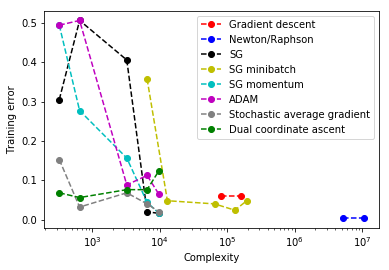

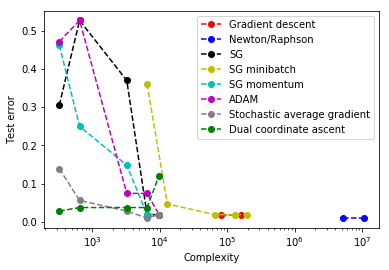

In [6]:
T = np.array([5, 10, 50, 100, 150])
train_errs_non_stoch = np.zeros((2, 2))
train_errs_stoch = np.zeros((6, 5))
test_errs_non_stoch = np.zeros((2, 2))
test_errs_stoch = np.zeros((6, 5))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
N_train = X_train.shape[0]
N_test = X_test.shape[0]
D = X.shape[1]
B = 20

for i in range((len(T))):
    if i < 2:
        bet_m = gradient_descent(X_train, y_train, bet_zero, taus[0], gammas[0], T[i])
        err = zero_one_loss(predict(bet_m, X_train), y_train)
        train_errs_non_stoch[0][i] = err / N_train
        err = zero_one_loss(predict(bet_m, X_test), y_test)
        test_errs_non_stoch[0][i] = err / N_test

        bet_m = newton_raphson(X_train, y_train, bet_zero, T[i])
        err = zero_one_loss(predict(bet_m, X_train), y_train)
        train_errs_non_stoch[1][i] = err / N_train
        err = zero_one_loss(predict(bet_m, X_test), y_test)
        test_errs_non_stoch[1][i] = err / N_test

    bet_m = stochastic_gradient(X_train, y_train, bet_zero, taus[2], gammas[2], T[i])
    err = zero_one_loss(predict(bet_m, X_train), y_train)
    train_errs_stoch[0][i] = err / N_train
    err = zero_one_loss(predict(bet_m, X_test), y_test)
    test_errs_stoch[0][i] = err / N_test

    bet_m = stochastic_gradient_minibatch(X_train, y_train, bet_zero, taus[0], gammas[0], T[i])
    err = zero_one_loss(predict(bet_m, X_train), y_train)
    train_errs_stoch[1][i] = err / N_train
    err = zero_one_loss(predict(bet_m, X_test), y_test)
    test_errs_stoch[1][i] = err / N_test

    bet_m = stochastic_gradient_momentum(X_train, y_train, bet_zero, taus[2], gammas[2],g_zero, mus[0], T[i])
    err = zero_one_loss(predict(bet_m, X_train), y_train)
    train_errs_stoch[2][i] = err / N_train
    err = zero_one_loss(predict(bet_m, X_test), y_test)
    test_errs_stoch[2][i] = err / N_test

    bet_m = ADAM(X_train, y_train, bet_zero, g_zero, T[i])
    err = zero_one_loss(predict(bet_m, X_train), y_train)
    train_errs_stoch[3][i] = err / N_train
    err = zero_one_loss(predict(bet_m, X_test), y_test)
    test_errs_stoch[3][i] = err / N_test

    bet_m = stochastic_average_gradient(X_train, y_train, bet_zero, taus[0], gammas[0], T[i])
    err = zero_one_loss(predict(bet_m, X_train), y_train)
    train_errs_stoch[4][i] = err / N_train
    err = zero_one_loss(predict(bet_m, X_test), y_test)
    test_errs_stoch[4][i] = err / N_test

    bet_m = dual_coordinate_ascent(X_train, y_train, T[i])
    err = zero_one_loss(predict(bet_m, X_train), y_train)
    train_errs_stoch[5][i] = err / N_train
    err = zero_one_loss(predict(bet_m, X_test), y_test)
    test_errs_stoch[5][i] = err / N_test


tmp = T * N_train * D
plt.plot(tmp[0:2], train_errs_non_stoch[0, :], color='r', marker='o', linestyle='dashed', label='Gradient descent')
tmp = T * N_train * D * D
plt.plot(tmp[0:2], train_errs_non_stoch[1, :], color='b', marker='o', linestyle='dashed', label='Newton/Raphson')
tmp = T * D
plt.plot(tmp, train_errs_stoch[0, :], color='k', marker='o', linestyle='dashed', label='SG')
tmp = T * B * D
plt.plot(tmp, train_errs_stoch[1, :], color='y', marker='o', linestyle='dashed', label='SG minibatch')
tmp = T * D
plt.plot(tmp, train_errs_stoch[2, :], color='c', marker='o', linestyle='dashed', label='SG momentum')
plt.plot(tmp, train_errs_stoch[3, :], color='m', marker='o', linestyle='dashed', label='ADAM')
plt.plot(tmp, train_errs_stoch[4, :], color='grey', marker='o', linestyle='dashed', label='Stochastic average gradient')
plt.plot(tmp, train_errs_stoch[5, :], color='g', marker='o', linestyle='dashed', label='Dual coordinate ascent')
plt.xscale('log')
plt.xlabel('Complexity')
plt.ylabel('Training error')
plt.legend(loc='upper right')
plt.show()


tmp = T * N_train * D
plt.plot(tmp[0:2], test_errs_non_stoch[0, :], color='r', marker='o', linestyle='dashed', label='Gradient descent')
tmp = T * N_train * D * D
plt.plot(tmp[0:2], test_errs_non_stoch[1, :], color='b', marker='o', linestyle='dashed', label='Newton/Raphson')
tmp = T * D
plt.plot(tmp, test_errs_stoch[0, :], color='k', marker='o', linestyle='dashed', label='SG')
tmp = T * B * D
plt.plot(tmp, test_errs_stoch[1, :], color='y', marker='o', linestyle='dashed', label='SG minibatch')
tmp = T * D
plt.plot(tmp, test_errs_stoch[2, :], color='c', marker='o', linestyle='dashed', label='SG momentum')
plt.plot(tmp, test_errs_stoch[3, :], color='m', marker='o', linestyle='dashed', label='ADAM')
plt.plot(tmp, test_errs_stoch[4, :], color='grey', marker='o', linestyle='dashed', label='Stochastic average gradient')
plt.plot(tmp, test_errs_stoch[5, :], color='g', marker='o', linestyle='dashed', label='Dual coordinate ascent')
plt.xscale('log')
plt.xlabel('Complexity')
plt.ylabel('Test error')
plt.legend(loc='upper right')
plt.show()

The fastest to converge is Newton/Raphson, but it is also the most complex. All algorithms that do not depend on stochastic variables converge faster but are also more complex. The stochastic algorithms sometimes get worse after a few iterations and then get better again later on. 